In [23]:
%matplotlib notebook

In [24]:
import glob
import numpy as np
from readts import TSFile
import matplotlib.pyplot as plt
from ase import io
from soprano.utils import minimum_periodic

In [25]:
class TSTrajectory(object):
    
    def __init__(self, name='CASTEP'):
        # Find the structure files
        files = sorted(glob.glob('outputs/CuVac-{}-*.cell'.format(name)))
        # Load them
        self.structs = [io.read(f) for f in files]
        # Energies?
        self.energies = np.loadtxt('outputs/CuVac-{}-E.dat'.format(name))
        self.energies -= self.energies[0]
        # Reaction coordinates?
        pos = [a.positions for a in self.structs]
        dpos = np.diff(pos, axis=0)
        shape = dpos.shape
        cell = self.structs[0].cell
        dpos = minimum_periodic(dpos.reshape((-1,3)), cell)[0].reshape(shape)
        r = np.linalg.norm(dpos, axis=(1,2))
        rcoords = np.concatenate([[0], np.cumsum(r)])
        self.rcoords = rcoords/rcoords[-1]

In [26]:
cst_tst = TSTrajectory('CASTEP')
ase_tst = TSTrajectory('ASE')
skt_tst = TSTrajectory('SOCKET')

<IPython.core.display.Javascript object>


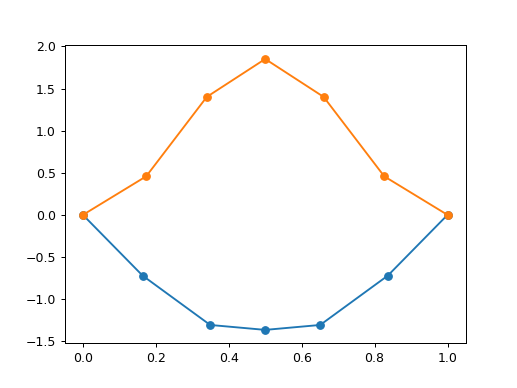

In [27]:
fig, ax = plt.subplots()

ax.plot(cst_tst.rcoords, cst_tst.energies, 'o-')
ax.plot(ase_tst.rcoords, ase_tst.energies, 'o-')

In [28]:
cst_tst.energies

array([ 0.00000000e+00, -7.20924000e-01, -1.30709900e+00, -1.36559300e+00,
       -1.30712600e+00, -7.20962000e-01,  6.00000001e-06])

In [29]:
ase_tst.energies

array([0.00000000e+00, 4.58114885e-01, 1.40096414e+00, 1.85133944e+00,
       1.40096496e+00, 4.58115538e-01, 2.41641374e-09])

In [30]:
skt_tst.energies

array([ 0.00000000e+00, -4.97964360e-05, -9.05885223e-05, -1.22375919e-04,
       -1.45158284e-04, -1.58935275e-04, -1.63706546e-04])